## Separación en train y validación

In [1]:
import pandas as pd

# Cargar el dataset original (sin imágenes aumentadas)
original_df = pd.read_csv("C:/Users/34629/TFG/single_label_dataset_without_H_no_O.csv")

# Definir las clases
classes = ['N', 'D', 'G', 'C', 'A', 'M']

# Añadir columna de clase dominante
def get_class_label(row):
    for c in classes:
        if row[c] == 1:
            return c
    return None

original_df['class_label'] = original_df.apply(get_class_label, axis=1)

# Dividir: 10% validación por clase
val_df = (
    original_df
    .groupby('class_label', group_keys=False)
    .apply(lambda x: x.sample(frac=0.10, random_state=42))
)

# Entrenamiento: el resto
train_df = original_df[~original_df['Image_Path'].isin(val_df['Image_Path'])]

# Guardar CSVs
train_path = "C:/Users/34629/TFG/train_DES.csv"
val_path   = "C:/Users/34629/TFG/val_DES.csv"
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)

# Confirmar resultados
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)


Train shape: (5220, 14)
Val shape: (580, 14)


C:\Users\34629\AppData\Local\Temp\ipykernel_19204\2436709630.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.10, random_state=42))


## Modelos

In [2]:
### Modelo 1 - Dataset desbalanceado ###

import os, sys, cv2, torch, argparse
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from PIL import Image
from torchvision import transforms
import tensorflow.keras.backend as K

# Config
IMG_SIZE   = 224
BATCH_SIZE = 16
EPOCHS     = 80
LABELS     = ['N', 'D', 'G', 'C', 'A', 'M']
LABEL_MAP  = {c: i for i, c in enumerate(LABELS)}

# Dataset
csv_path = "C:/Users/34629/TFG/train_DES.csv"
paths = pd.read_csv(csv_path)
paths["class_label"] = paths[LABELS].idxmax(axis=1)
paths["label"] = paths["class_label"].map(LABEL_MAP)

image_paths = paths["Image_Path"].tolist()
y = paths["label"].values

# Comprobación previa de features
rf_path = "C:/Users/34629/Downloads/X_rf_train_DES.npy"
y_path  = "C:/Users/34629/Downloads/y_train_DES.npy"

if os.path.exists(rf_path) and os.path.exists(y_path):
    X_rf = np.load(rf_path)
    y = np.load(y_path)
    print("✅ Features cargadas desde disco.")
else:
    sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
    from models_vit import RETFound_mae
    from util.pos_embed import interpolate_pos_embed
    torch.serialization.add_safe_globals([argparse.Namespace])

    def extract_features(img_paths, weights_path):
        model = RETFound_mae(global_pool=True, img_size=IMG_SIZE)
        ckpt = torch.load(weights_path, map_location='cpu', weights_only=False)
        sd = ckpt['model']
        sd.pop('head.weight', None)
        sd.pop('head.bias', None)
        interpolate_pos_embed(model, sd)
        model.load_state_dict(sd, strict=False)
        model.eval()

        feats = []
        for p in tqdm(img_paths, desc="Extrayendo RETFound"):
            img = cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE)) / 255.0
            x = torch.from_numpy(img.astype('float32')).permute(2,0,1).unsqueeze(0)
            with torch.no_grad():
                f = model.forward_features(x).cpu().numpy().squeeze()
            feats.append(f)
        return np.stack(feats)

    X_rf = extract_features(image_paths, "C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth")
    np.save(rf_path, X_rf)
    np.save(y_path, y)

# Validación separada
val_csv = pd.read_csv("C:/Users/34629/TFG/val_DES.csv")
val_csv["class_label"] = val_csv[LABELS].idxmax(axis=1)
val_csv["label"] = val_csv["class_label"].map(LABEL_MAP)
val_paths = val_csv["Image_Path"].tolist()
y_val = val_csv["label"].values

# Cargar features validación
X_rf_val_path = "C:/Users/34629/Downloads/X_rf_val_DES.npy"
y_val_path    = "C:/Users/34629/Downloads/y_val_DES.npy"

if os.path.exists(X_rf_val_path) and os.path.exists(y_val_path):
    X_vl = np.load(X_rf_val_path)
    y_val = np.load(y_val_path)
    print("✅ Validación cargada.")
else:
    X_vl = extract_features(val_paths, "C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth")
    np.save(X_rf_val_path, X_vl)
    np.save(y_val_path, y_val)

# One-hot
y_tr_cat = to_categorical(y, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_val, num_classes=len(LABELS))

# Modelo

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return loss

inp = Input((X_rf.shape[1],))
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(inp)
x = LayerNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.5)(x)

x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
x = LayerNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
x = LayerNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)

out = Dense(len(LABELS), activation='softmax')(x)
m = Model(inp, out)

loss_fn = categorical_focal_loss(gamma=2.0, alpha=0.25)
m.compile(optimizer=Adam(1e-4), loss=loss_fn,
          metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro', name='f1')])

cb = [
    EarlyStopping('val_f1', mode='max', patience=60, restore_best_weights=True),
    ModelCheckpoint("modelo1_DESB.h5", monitor='val_f1', mode='max', save_best_only=True)
]

m.fit(X_rf, y_tr_cat, validation_data=(X_vl, y_vl_cat),
      epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, verbose=2)

# Inference
probs = m.predict(X_vl)
y_pred = probs.argmax(axis=1)

print(classification_report(y_val, y_pred, target_names=LABELS))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Matriz de Confusión - Modelo 1 DESB")
plt.tight_layout()
plt.savefig("confusion_matrix_modelo1_DES.png")
plt.close()

# ROC
y_val_bin = label_binarize(y_val, classes=np.arange(len(LABELS)))
plt.figure(figsize=(10, 7))
for i in range(len(LABELS)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{LABELS[i]} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curvas ROC - Modelo 1 DESB")
plt.legend(); plt.tight_layout()
plt.savefig("curvas_ROC_modelo1_DES.png")
plt.close()

# Grad-CAM
def generar_gradcam(img_path, nombre_archivo):
    model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu')
    sd = ckpt['model']
    sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(model, sd)
    model.load_state_dict(sd, strict=False); model.eval()
    activations = {}
    model.blocks[11].register_forward_hook(lambda m, i, o: activations.update({'value': o}))
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad(): model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14, 14)
    cam = cv2.resize((cam - cam.min()) / (cam.max() - cam.min()), (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * cam)
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    cv2.imwrite(nombre_archivo, cv2.cvtColor(np.uint8(superpuesta), cv2.COLOR_RGB2BGR))

df_res = pd.DataFrame({
    "img": val_paths,
    "true": [LABELS[i] for i in y_val],
    "pred": [LABELS[i] for i in y_pred]
})
df_res["correct"] = df_res["true"] == df_res["pred"]

bien = df_res[df_res["correct"]].iloc[0]
mal = df_res[~df_res["correct"]].iloc[0]
generar_gradcam(bien["img"], f"gradcam_modelo1_DES_correcto_{bien['true']}.png")
generar_gradcam(mal["img"], f"gradcam_modelo1_DES_error_{mal['true']}_pred{mal['pred']}.png")


✅ Features cargadas desde disco.
✅ Validación cargada.
Epoch 1/80

327/327 - 10s - loss: 1.9708 - accuracy: 0.4626 - f1: 0.1711 - val_loss: 1.6452 - val_accuracy: 0.5345 - val_f1: 0.1161 - 10s/epoch - 30ms/step
Epoch 2/80


c:\Users\34629\TFG\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


327/327 - 8s - loss: 1.4526 - accuracy: 0.4847 - f1: 0.2100 - val_loss: 1.2422 - val_accuracy: 0.5483 - val_f1: 0.1933 - 8s/epoch - 24ms/step
Epoch 3/80
327/327 - 9s - loss: 1.1480 - accuracy: 0.4960 - f1: 0.2811 - val_loss: 1.0051 - val_accuracy: 0.5603 - val_f1: 0.3908 - 9s/epoch - 26ms/step
Epoch 4/80
327/327 - 8s - loss: 0.9516 - accuracy: 0.5167 - f1: 0.3319 - val_loss: 0.8496 - val_accuracy: 0.5741 - val_f1: 0.3465 - 8s/epoch - 26ms/step
Epoch 5/80
327/327 - 9s - loss: 0.8161 - accuracy: 0.5420 - f1: 0.3720 - val_loss: 0.7423 - val_accuracy: 0.5603 - val_f1: 0.4013 - 9s/epoch - 27ms/step
Epoch 6/80
327/327 - 8s - loss: 0.7115 - accuracy: 0.5448 - f1: 0.3868 - val_loss: 0.6603 - val_accuracy: 0.5793 - val_f1: 0.3192 - 8s/epoch - 24ms/step
Epoch 7/80
327/327 - 9s - loss: 0.6292 - accuracy: 0.5466 - f1: 0.3892 - val_loss: 0.5758 - val_accuracy: 0.5655 - val_f1: 0.4140 - 9s/epoch - 27ms/step
Epoch 8/80
327/327 - 9s - loss: 0.5595 - accuracy: 0.5563 - f1: 0.3990 - val_loss: 0.5249 - v

c:\Users\34629\TFG\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\34629\TFG\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\34629\TFG\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
### Modelo 2 - Dataset Desbalanceado ###

import os, sys, cv2, numpy as np, pandas as pd, torch, argparse
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Config
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 80
LABELS = ['N','D','G','C','A','M']
LABEL_MAP = {c:i for i,c in enumerate(LABELS)}
ENSEMBLE_W = 0.7

# Añadir RETFound
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed
torch.serialization.add_safe_globals([argparse.Namespace])

# Paths
rf_train_path = "C:/Users/34629/Downloads/X_rf_train_DES.npy"
rf_val_path   = "C:/Users/34629/Downloads/X_rf_val_DES.npy"
eff_train_path = "C:/Users/34629/Downloads/X_eff_train_DES.npy"
eff_val_path   = "C:/Users/34629/Downloads/X_eff_val_DES.npy"
y_train_path = "C:/Users/34629/Downloads/y_train_DES.npy"
y_val_path   = "C:/Users/34629/Downloads/y_val_DES.npy"

train_df = pd.read_csv("C:/Users/34629/TFG/train_DES.csv")
val_df = pd.read_csv("C:/Users/34629/TFG/val_DES.csv")

train_df['label'] = train_df['class_label'].map(LABEL_MAP)
val_df['label'] = val_df['class_label'].map(LABEL_MAP)

train_paths = train_df['Image_Path'].tolist()
val_paths = val_df['Image_Path'].tolist()
y_tr = train_df['label'].values
y_vl = val_df['label'].values

# Función extracción EfficientNet
from tensorflow.keras.applications import EfficientNetB3, efficientnet
eff_model = EfficientNetB3(include_top=False, pooling='avg', weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
def extract_eff_features(paths):
    feats = []
    for p in tqdm(paths, desc="EffNet feats"):
        img = cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE))
        x = efficientnet.preprocess_input(img.astype('float32'))
        feats.append(eff_model(np.expand_dims(x, 0), training=False).numpy().squeeze())
    return np.stack(feats)

# Cargar o extraer características
if all(os.path.exists(p) for p in [rf_train_path, rf_val_path, y_train_path, y_val_path]):
    X1_tr = np.load(rf_train_path)
    X1_vl = np.load(rf_val_path)
    y_tr  = np.load(y_train_path)
    y_vl  = np.load(y_val_path)
    print("✅ RETFound cargado de disco.")
else:
    def extract_retfound_features(paths):
        model = RETFound_mae(global_pool=True, img_size=IMG_SIZE)
        ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu')
        sd = ckpt['model']; sd.pop('head.weight', None); sd.pop('head.bias', None)
        interpolate_pos_embed(model, sd)
        model.load_state_dict(sd, strict=False); model.eval()
        feats = []
        for p in tqdm(paths, desc="RETFound feats"):
            img = cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE)) / 255.0
            x = torch.from_numpy(img.astype('float32')).permute(2,0,1).unsqueeze(0)
            with torch.no_grad():
                f = model.forward_features(x).cpu().numpy().squeeze()
            feats.append(f)
        return np.stack(feats)

    X1_tr = extract_retfound_features(train_paths)
    X1_vl = extract_retfound_features(val_paths)
    np.save(rf_train_path, X1_tr)
    np.save(rf_val_path, X1_vl)
    np.save(y_train_path, y_tr)
    np.save(y_val_path, y_vl)

if all(os.path.exists(p) for p in [eff_train_path, eff_val_path]):
    X2_tr = np.load(eff_train_path)
    X2_vl = np.load(eff_val_path)
    print("✅ EfficientNet cargado de disco.")
else:
    X2_tr = extract_eff_features(train_paths)
    X2_vl = extract_eff_features(val_paths)
    np.save(eff_train_path, X2_tr)
    np.save(eff_val_path, X2_vl)

# One-hot
y_tr_cat = to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_vl, num_classes=len(LABELS))

# Modelos
inp1 = Input((X1_tr.shape[1],))
x = Dense(1024)(inp1); x = LayerNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.5)(x); x = Dense(512)(x); x = LayerNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.4)(x); x = Dense(256)(x); x = LayerNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x); out1 = Dense(len(LABELS), activation='softmax')(x)
m1 = Model(inp1, out1)

inp2 = Input((X2_tr.shape[1],))
y_ = Dense(512, activation='relu')(inp2)
out2 = Dense(len(LABELS), activation='softmax')(y_)
m2 = Model(inp2, out2)

loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False)
for model in [m1, m2]:
    model.compile(optimizer=Adam(1e-4),
                  loss=loss_fn,
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro', name='f1')])

cb_rf = [EarlyStopping('val_f1', mode='max', patience=10, restore_best_weights=True),
         ModelCheckpoint("Clas_DES_rf_modelo2.h5", monitor='val_f1', save_best_only=True)]
cb_eff = [EarlyStopping('val_f1', mode='max', patience=10, restore_best_weights=True),
          ModelCheckpoint("Clas_DES_eff_modelo2.h5", monitor='val_f1', save_best_only=True)]

# Entrenamiento
m1.fit(X1_tr, y_tr_cat, validation_data=(X1_vl, y_vl_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb_rf, verbose=2)
m2.fit(X2_tr, y_tr_cat, validation_data=(X2_vl, y_vl_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb_eff, verbose=2)

# Ensemble + umbrales
p1 = m1.predict(X1_vl)
p2 = m2.predict(X2_vl)
probs = ENSEMBLE_W * p1 + (1 - ENSEMBLE_W) * p2
THRESH = np.ones(len(LABELS)) * 0.5
for i in range(len(LABELS)):
    prec, rec, thr = precision_recall_curve((y_vl == i).astype(int), probs[:, i])
    F = 2 * prec * rec / (prec + rec + 1e-8)
    THRESH[i] = thr[np.nanargmax(F)]

y_pred = []
for row in probs:
    sel = np.where(row >= THRESH)[0]
    if len(sel) == 1: y_pred.append(sel[0])
    elif len(sel) > 1: y_pred.append(sel[np.argmax(row[sel])])
    else: y_pred.append(int(np.argmax(row)))
y_pred = np.array(y_pred)

# Reporte
print(classification_report(y_vl, y_pred, target_names=LABELS))
cm = confusion_matrix(y_vl, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Matriz Confusión Modelo 2 DES")
plt.tight_layout()
plt.savefig("matriz_confusion_modelo2_DES.png")
plt.close()

# ROC
y_true_bin = label_binarize(y_vl, classes=np.arange(len(LABELS)))
plt.figure(figsize=(10,7))
for i in range(len(LABELS)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{LABELS[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("Curva ROC Modelo 2 DES"); plt.legend()
plt.tight_layout()
plt.savefig("curva_ROC_modelo2_DES.png")
plt.close()

# Grad-CAM
def generar_gradcam(img_path, nombre_archivo):
    model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu')
    sd = ckpt['model']; sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(model, sd)
    model.load_state_dict(sd, strict=False); model.eval()
    activations = {}
    model.blocks[11].register_forward_hook(lambda m, i, o: activations.update({'value': o}))
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad(): model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14, 14)
    cam = cv2.resize((cam - cam.min()) / (cam.max() - cam.min()), (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * cam)
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    cv2.imwrite(nombre_archivo, cv2.cvtColor(np.uint8(superpuesta), cv2.COLOR_RGB2BGR))

df_res = pd.DataFrame({'img': val_paths, 'true': y_vl, 'pred': y_pred})
df_res['correct'] = df_res['true'] == df_res['pred']
bien = df_res[df_res['correct']].iloc[0]
mal  = df_res[~df_res['correct']].iloc[0]
generar_gradcam(bien['img'], f"gradcam_DES_modelo2_correcto_{LABELS[bien['pred']]}.png")
generar_gradcam(mal['img'],  f"gradcam_DES_modelo2_error_{LABELS[mal['true']]}_pred{LABELS[mal['pred']]}.png")


✅ RETFound cargado de disco.


EffNet feats: 100%|██████████| 580/580 [03:30<00:00,  2.75it/s]


Epoch 1/80
327/327 - 8s - loss: 0.3126 - accuracy: 0.4161 - f1: 0.1770 - val_loss: 0.2166 - val_accuracy: 0.5379 - val_f1: 0.1295 - 8s/epoch - 25ms/step
Epoch 2/80


c:\Users\34629\TFG\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


327/327 - 6s - loss: 0.2521 - accuracy: 0.4728 - f1: 0.1930 - val_loss: 0.2084 - val_accuracy: 0.5397 - val_f1: 0.1418 - 6s/epoch - 19ms/step
Epoch 3/80
327/327 - 6s - loss: 0.2330 - accuracy: 0.4927 - f1: 0.2232 - val_loss: 0.1993 - val_accuracy: 0.5310 - val_f1: 0.2767 - 6s/epoch - 19ms/step
Epoch 4/80
327/327 - 6s - loss: 0.2176 - accuracy: 0.5125 - f1: 0.2758 - val_loss: 0.1910 - val_accuracy: 0.5534 - val_f1: 0.2587 - 6s/epoch - 19ms/step
Epoch 5/80
327/327 - 6s - loss: 0.2063 - accuracy: 0.5289 - f1: 0.3278 - val_loss: 0.1852 - val_accuracy: 0.5586 - val_f1: 0.3556 - 6s/epoch - 19ms/step
Epoch 6/80
327/327 - 6s - loss: 0.2000 - accuracy: 0.5500 - f1: 0.3610 - val_loss: 0.1813 - val_accuracy: 0.5724 - val_f1: 0.3856 - 6s/epoch - 19ms/step
Epoch 7/80
327/327 - 6s - loss: 0.1943 - accuracy: 0.5594 - f1: 0.3865 - val_loss: 0.1779 - val_accuracy: 0.5759 - val_f1: 0.4265 - 6s/epoch - 19ms/step
Epoch 8/80
327/327 - 6s - loss: 0.1890 - accuracy: 0.5718 - f1: 0.4050 - val_loss: 0.1771 - v

In [4]:
# === MODELO 3 - DESBALANCEADO con MIXUP y ENSEMBLE ===

import os, sys, cv2, numpy as np, pandas as pd, torch, argparse
from tqdm import tqdm
from sklearn.utils import compute_class_weight
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import EfficientNetB3, efficientnet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
import tensorflow as tf
from PIL import Image
from torchvision import transforms
import tensorflow.keras.backend as K

# --- Configuración general ---
IMG_SIZE     = 224
BATCH_SIZE   = 16
EPOCHS       = 80
ENSEMBLE_W   = 0.7
LABEL_SMOOTH = 0.1
LABELS = ['N', 'D', 'G', 'C', 'A', 'M']
LABEL_MAP = {c: i for i, c in enumerate(LABELS)}

# --- MixUp ---
def mixup(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(x))
    return lam * x + (1 - lam) * x[idx], lam * y + (1 - lam) * y[idx]

# --- Carga de CSV ---
train_df = pd.read_csv("C:/Users/34629/TFG/train_DES.csv")
val_df = pd.read_csv("C:/Users/34629/TFG/val_DES.csv")
train_paths = train_df['Image_Path'].tolist()
val_paths = val_df['Image_Path'].tolist()
y_tr = train_df['class_label'].map(LABEL_MAP).values
y_vl = val_df['class_label'].map(LABEL_MAP).values

# --- Cargar o Extraer Características ---
# RETFound
X1_tr_path = "C:/Users/34629/Downloads/X_rf_train_DES.npy"
X1_vl_path = "C:/Users/34629/Downloads/X_rf_val_DES.npy"
y_tr_path = "C:/Users/34629/Downloads/y_train_DES.npy"
y_vl_path = "C:/Users/34629/Downloads/y_val_DES.npy"

# EfficientNet
X2_tr_path = "C:/Users/34629/Downloads/X_eff_train_DES.npy"
X2_vl_path = "C:/Users/34629/Downloads/X_eff_val_DES.npy"

# Funciones de extracción
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

torch.serialization.add_safe_globals([argparse.Namespace])

def extract_retfound_features(paths, weights_path):
    model = RETFound_mae(global_pool=True, img_size=IMG_SIZE)
    ckpt = torch.load(weights_path, map_location='cpu', weights_only=False)
    sd = ckpt['model']
    sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(model, sd)
    model.load_state_dict(sd, strict=False)
    model.eval()
    feats = []
    for p in tqdm(paths, desc="RETFound feats"):
        img = cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE)) / 255.0
        x = torch.from_numpy(img.astype('float32')).permute(2,0,1).unsqueeze(0)
        with torch.no_grad():
            f = model.forward_features(x).cpu().numpy().squeeze()
        feats.append(f)
    return np.stack(feats)

def extract_eff_features(paths):
    model = EfficientNetB3(include_top=False, pooling='avg', weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    feats = []
    for p in tqdm(paths, desc="EffNet feats"):
        img = cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE))
        x = efficientnet.preprocess_input(img.astype('float32'))
        feats.append(model(np.expand_dims(x, 0), training=False).numpy().squeeze())
    return np.stack(feats)

# RETFound
if all(os.path.exists(p) for p in [X1_tr_path, X1_vl_path, y_tr_path, y_vl_path]):
    X1_tr = np.load(X1_tr_path); X1_vl = np.load(X1_vl_path)
    y_tr = np.load(y_tr_path); y_vl = np.load(y_vl_path)
else:
    X1_tr = extract_retfound_features(train_paths, "C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth")
    X1_vl = extract_retfound_features(val_paths, "C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth")
    np.save(X1_tr_path, X1_tr); np.save(X1_vl_path, X1_vl)
    np.save(y_tr_path, y_tr); np.save(y_vl_path, y_vl)

# EfficientNet
if all(os.path.exists(p) for p in [X2_tr_path, X2_vl_path]):
    X2_tr = np.load(X2_tr_path); X2_vl = np.load(X2_vl_path)
else:
    X2_tr = extract_eff_features(train_paths)
    X2_vl = extract_eff_features(val_paths)
    np.save(X2_tr_path, X2_tr); np.save(X2_vl_path, X2_vl)

# --- One-hot y suavizado ---
y_tr_cat = to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_vl, num_classes=len(LABELS))
y_tr_cat = y_tr_cat * (1 - LABEL_SMOOTH) + LABEL_SMOOTH / len(LABELS)

# --- MixUp en RETFound ---
X1_tr, y_tr_cat = mixup(X1_tr, y_tr_cat)


# --- Modelos ---

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=-1)
    return loss


inp1 = Input((X1_tr.shape[1],))
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(inp1)
x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.5)(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.4)(x)
x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)
out1 = Dense(len(LABELS), activation='softmax')(x)
m1 = Model(inp1, out1)

inp2 = Input((X2_tr.shape[1],))
y_ = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(inp2)
y_ = BatchNormalization()(y_); y_ = LeakyReLU(0.1)(y_); y_ = Dropout(0.4)(y_)
out2 = Dense(len(LABELS), activation='softmax')(y_)
m2 = Model(inp2, out2)

loss_fn = categorical_focal_loss(gamma=2.0, alpha=0.25)

m1.compile(optimizer=Adam(1e-4), loss=loss_fn,
           metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro')])

m2.compile(optimizer=Adam(1e-4), loss=loss_fn,
           metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro')])

m1.fit(X1_tr, y_tr_cat, validation_data=(X1_vl, y_vl_cat), epochs=EPOCHS,
       batch_size=BATCH_SIZE, verbose=2)
m2.fit(X2_tr, y_tr_cat, validation_data=(X2_vl, y_vl_cat), epochs=EPOCHS,
       batch_size=BATCH_SIZE, verbose=2)

# --- Ensemble e inferencia ---
p1 = m1.predict(X1_vl)
p2 = m2.predict(X2_vl)
probs = ENSEMBLE_W * p1 + (1 - ENSEMBLE_W) * p2
y_true = y_vl

# --- Ajuste de umbrales ---
THRESH = np.ones(len(LABELS)) * 0.5
y_vl_bin = label_binarize(y_true, classes=np.arange(len(LABELS)))
for i in range(len(LABELS)):
    prec, rec, thr = precision_recall_curve((y_true == i).astype(int), probs[:, i])
    F = 2 * prec * rec / (prec + rec + 1e-8)
    THRESH[i] = thr[np.nanargmax(F)]

y_pred = []
for row in probs:
    sel = np.where(row >= THRESH)[0]
    if len(sel) == 1: y_pred.append(sel[0])
    elif len(sel) > 1: y_pred.append(sel[np.argmax(row[sel])])
    else: y_pred.append(int(np.argmax(row)))
y_pred = np.array(y_pred)

# --- Reporte ---
print("\n📋 Classification Report (Modelo 3 DES):")
print(classification_report(y_true, y_pred, target_names=LABELS))

cm = confusion_matrix(y_true, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Matriz de Confusión - Modelo 3 DES")
plt.savefig("matriz_confusion_modelo3_DES.png"); plt.close()

plt.figure(figsize=(10, 7))
for i in range(len(LABELS)):
    fpr, tpr, _ = roc_curve(y_vl_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{LABELS[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Curvas ROC - Modelo 3 DES")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig("curva_ROC_modelo3_DES.png"); plt.close()

# --- Grad-CAM ---
def generar_gradcam(img_path, nombre_archivo):
    ret_model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu')
    sd = ckpt['model']
    sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(ret_model, sd)
    ret_model.load_state_dict(sd, strict=False); ret_model.eval()
    activations = {}
    ret_model.blocks[11].register_forward_hook(lambda m, i, o: activations.update({'value': o}))
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad(): ret_model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14, 14)
    cam = cv2.resize((cam - cam.min()) / (cam.max() - cam.min()), (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * cam); cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    cv2.imwrite(nombre_archivo, cv2.cvtColor(np.uint8(superpuesta), cv2.COLOR_RGB2BGR))

# Una imagen correcta y una errónea
df_res = pd.DataFrame({'img': val_paths[:len(y_true)], 'true': y_true, 'pred': y_pred})
df_res['correcto'] = df_res['true'] == df_res['pred']
bien = df_res[df_res['correcto']].iloc[0]
mal = df_res[~df_res['correcto']].iloc[0]

generar_gradcam(bien['img'], f"gradcam_modelo3_DES_correcto_{LABELS[bien['pred']]}.png")
generar_gradcam(mal['img'], f"gradcam_modelo3_DES_error_{LABELS[mal['true']]}_pred{LABELS[mal['pred']]}.png")


Epoch 1/80

327/327 - 10s - loss: 2.2788 - accuracy: 0.4128 - f1_score: 0.2564 - val_loss: 2.0826 - val_accuracy: 0.5500 - val_f1_score: 0.4365 - 10s/epoch - 30ms/step
Epoch 2/80
327/327 - 7s - loss: 2.1048 - accuracy: 0.5067 - f1_score: 0.3193 - val_loss: 1.9519 - val_accuracy: 0.5500 - val_f1_score: 0.4777 - 7s/epoch - 23ms/step
Epoch 3/80
327/327 - 8s - loss: 1.9687 - accuracy: 0.5148 - f1_score: 0.3321 - val_loss: 1.8218 - val_accuracy: 0.5759 - val_f1_score: 0.5010 - 8s/epoch - 24ms/step
Epoch 4/80
327/327 - 8s - loss: 1.8385 - accuracy: 0.5276 - f1_score: 0.3493 - val_loss: 1.6918 - val_accuracy: 0.5621 - val_f1_score: 0.4931 - 8s/epoch - 25ms/step
Epoch 5/80
327/327 - 8s - loss: 1.7028 - accuracy: 0.5370 - f1_score: 0.3563 - val_loss: 1.5631 - val_accuracy: 0.6069 - val_f1_score: 0.5142 - 8s/epoch - 24ms/step
Epoch 6/80
327/327 - 7s - loss: 1.5815 - accuracy: 0.5324 - f1_score: 0.3559 - val_loss: 1.4447 - val_accuracy: 0.5948 - val_f1_score: 0.4823 - 7s/epoch - 22ms/step
Epoch 7

In [5]:
# MODELO 4 CON CUTMIX - Dataset DESBALANCEADO
# ============================================

import os, sys, cv2, numpy as np, pandas as pd, torch, argparse
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import compute_class_weight
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms

# CONFIGURACIÓN
IMG_SIZE     = 224
BATCH_SIZE   = 16
EPOCHS       = 80
SMOTE_K      = 5
ENSEMBLE_W   = 0.7
LABEL_SMOOTH = 0.1
LABELS       = ['N', 'D', 'G', 'C', 'A', 'M']
THRESH       = np.ones(len(LABELS)) * 0.5

# CUTMIX
def cutmix(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.shape[0]
    idx = np.random.permutation(batch_size)
    cut_ratio = np.sqrt(1. - lam)
    feat_len = x.shape[1]
    cut_len = int(feat_len * cut_ratio)
    start = np.random.randint(0, feat_len - cut_len)
    end = start + cut_len
    x_cutmix = x.copy()
    x_cutmix[:, start:end] = x[idx, start:end]
    y_cutmix = lam * y + (1 - lam) * y[idx]
    return x_cutmix, y_cutmix

# CARGA DE CARACTERÍSTICAS
X1_tr = np.load("C:/Users/34629/Downloads/X_rf_train_DES.npy")
X2_tr = np.load("C:/Users/34629/Downloads/X_eff_train_DES.npy")
y_tr  = np.load("C:/Users/34629/Downloads/y_train_DES.npy")
X1_vl = np.load("C:/Users/34629/Downloads/X_rf_val_DES.npy")
X2_vl = np.load("C:/Users/34629/Downloads/X_eff_val_DES.npy")
y_vl  = np.load("C:/Users/34629/Downloads/y_val_DES.npy")

y_tr_cat = to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_vl, num_classes=len(LABELS))

# SMOTE
sm = SMOTE(k_neighbors=SMOTE_K, random_state=42)
X1_tr, yidx = sm.fit_resample(X1_tr, y_tr)
y_tr_cat_rf = to_categorical(yidx, num_classes=len(LABELS))

# Label smoothing
y_tr_cat_rf = y_tr_cat_rf * (1 - LABEL_SMOOTH) + LABEL_SMOOTH / len(LABELS)
y_tr_cat_eff = y_tr_cat * (1 - LABEL_SMOOTH) + LABEL_SMOOTH / len(LABELS)

# CUTMIX
X1_tr, y_tr_cat_rf = cutmix(X1_tr, y_tr_cat_rf, alpha=1.0)

# Pesos de clase
cw_rf = compute_class_weight('balanced', classes=np.arange(len(LABELS)), y=np.argmax(y_tr_cat_rf, axis=1))
cw_eff = compute_class_weight('balanced', classes=np.arange(len(LABELS)), y=np.argmax(y_tr_cat_eff, axis=1))
cw_rf = {i: w for i, w in enumerate(cw_rf)}
cw_eff = {i: w for i, w in enumerate(cw_eff)}

# MODELOS
inp1 = Input((X1_tr.shape[1],))
x = Dense(1024)(inp1); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.5)(x); x = Dense(512)(x); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.4)(x); x = Dense(256)(x); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)
out1 = Dense(len(LABELS), activation='softmax')(x)
m1 = Model(inp1, out1)

inp2 = Input((X2_tr.shape[1],))
y_ = Dense(512)(inp2); y_ = BatchNormalization()(y_); y_ = LeakyReLU(0.1)(y_)
y_ = Dropout(0.4)(y_); out2 = Dense(len(LABELS), activation='softmax')(y_)
m2 = Model(inp2, out2)

loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False)

for model, cw in [(m1, cw_rf), (m2, cw_eff)]:
    model.compile(optimizer=Adam(1e-4), loss=loss_fn,
                  metrics=['accuracy', tfa.metrics.F1Score(len(LABELS), 'macro', name='f1')])

# ENTRENAMIENTO
m1.fit(X1_tr, y_tr_cat_rf, validation_data=(X1_vl, y_vl_cat), epochs=EPOCHS,
       batch_size=BATCH_SIZE, class_weight=cw_rf, verbose=2)
m2.fit(X2_tr, y_tr_cat_eff, validation_data=(X2_vl, y_vl_cat), epochs=EPOCHS,
       batch_size=BATCH_SIZE, class_weight=cw_eff, verbose=2)

# ENSEMBLE
p1 = m1.predict(X1_vl)
p2 = m2.predict(X2_vl)
probs = ENSEMBLE_W * p1 + (1 - ENSEMBLE_W) * p2

for i in range(len(LABELS)):
    prec, rec, thr = precision_recall_curve((y_vl == i).astype(int), probs[:, i])
    F = 2 * prec * rec / (prec + rec + 1e-8)
    THRESH[i] = thr[np.nanargmax(F)]

y_pred = []
for row in probs:
    sel = np.where(row >= THRESH)[0]
    if len(sel) == 1: y_pred.append(sel[0])
    elif len(sel) > 1: y_pred.append(sel[np.argmax(row[sel])])
    else: y_pred.append(np.argmax(row))
y_pred = np.array(y_pred)

# MÉTRICAS
print(classification_report(y_vl, y_pred, target_names=LABELS))
cm = confusion_matrix(y_vl, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title("Matriz Confusión - Modelo 4 DES")
plt.tight_layout()
plt.savefig("matriz_confusion_modelo4_DES.png")
plt.close()

# ROC
from sklearn.preprocessing import label_binarize
y_vl_bin = label_binarize(y_vl, classes=np.arange(len(LABELS)))
plt.figure(figsize=(10, 8))
for i in range(len(LABELS)):
    fpr, tpr, _ = roc_curve(y_vl_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{LABELS[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(); plt.title("Curvas ROC - Modelo 4 DES"); plt.tight_layout()
plt.savefig("curva_ROC_modelo4_DES.png")
plt.close()

# GRAD-CAM
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

def generar_gradcam(img_path, nombre_archivo):
    model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu')
    sd = ckpt['model']; sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(model, sd); model.load_state_dict(sd, strict=False)
    model.eval()
    activations = {}
    model.blocks[11].register_forward_hook(lambda m, i, o: activations.update({'value': o}))
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad(): model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14, 14)
    cam = cv2.resize((cam - cam.min()) / (cam.max() - cam.min()), (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * cam); cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    cv2.imwrite(nombre_archivo, cv2.cvtColor(np.uint8(superpuesta), cv2.COLOR_RGB2BGR))

# GENERAR EJEMPLOS
val_df = pd.read_csv("C:/Users/34629/TFG/val_DES.csv")
paths = val_df['Image_Path'].tolist()
df_res = pd.DataFrame({'img': paths, 'true': y_vl, 'pred': y_pred})
df_res['correct'] = df_res['true'] == df_res['pred']
bien = df_res[df_res['correct']].iloc[0]
mal  = df_res[~df_res['correct']].iloc[0]
generar_gradcam(bien['img'], f"gradcam_modelo4_DES_bien_{LABELS[bien['true']]}.png")
generar_gradcam(mal['img'],  f"gradcam_modelo4_DES_mal_{LABELS[mal['true']]}_pred{LABELS[mal['pred']]}.png")

Epoch 1/80
1047/1047 - 180s - loss: 0.2846 - accuracy: 0.4279 - f1: 0.3295 - val_loss: 0.2702 - val_accuracy: 0.3845 - val_f1: 0.4131 - 180s/epoch - 172ms/step
Epoch 2/80
1047/1047 - 98s - loss: 0.2371 - accuracy: 0.5014 - f1: 0.3796 - val_loss: 0.2618 - val_accuracy: 0.3897 - val_f1: 0.4342 - 98s/epoch - 94ms/step
Epoch 3/80
1047/1047 - 98s - loss: 0.2203 - accuracy: 0.5313 - f1: 0.3992 - val_loss: 0.2691 - val_accuracy: 0.3690 - val_f1: 0.4342 - 98s/epoch - 94ms/step
Epoch 4/80
1047/1047 - 94s - loss: 0.2092 - accuracy: 0.5592 - f1: 0.4157 - val_loss: 0.2493 - val_accuracy: 0.3741 - val_f1: 0.4200 - 94s/epoch - 90ms/step
Epoch 5/80
1047/1047 - 101s - loss: 0.2015 - accuracy: 0.5812 - f1: 0.4306 - val_loss: 0.2451 - val_accuracy: 0.3931 - val_f1: 0.4563 - 101s/epoch - 96ms/step
Epoch 6/80
1047/1047 - 93s - loss: 0.1933 - accuracy: 0.6149 - f1: 0.4507 - val_loss: 0.2499 - val_accuracy: 0.3741 - val_f1: 0.4440 - 93s/epoch - 89ms/step
Epoch 7/80
1047/1047 - 97s - loss: 0.1889 - accuracy:

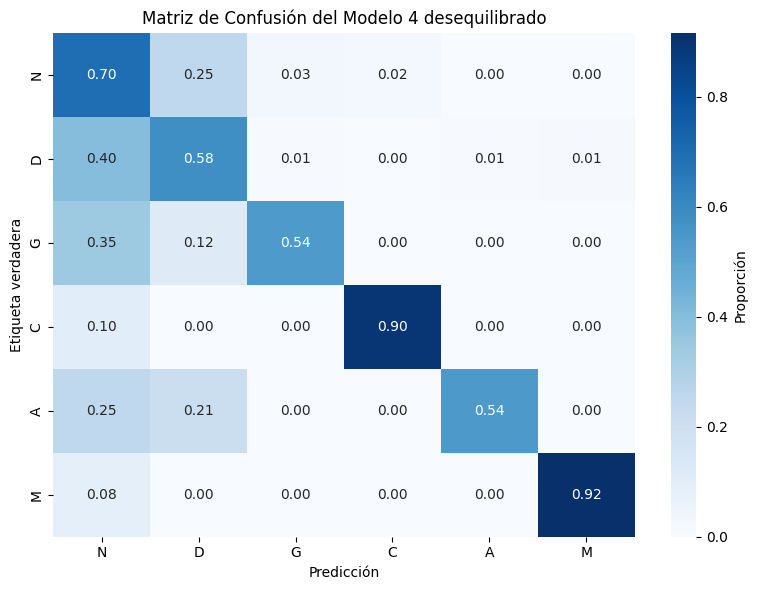

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ejemplo de matriz de confusión real (de tu imagen)
conf_matrix = np.array([
    [216, 77, 9, 6, 1, 1],
    [66, 97, 1, 0, 1, 2],
    [9, 3, 14, 0, 0, 0],
    [3, 0, 0, 26, 0, 0],
    [6, 5, 0, 0, 13, 0],
    [2, 0, 0, 0, 0, 22]
])

# Nombres de clases
labels = ['N', 'D', 'G', 'C', 'A', 'M']

# Normalizar por fila (suma por cada clase real)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_normalized = conf_matrix / row_sums

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proporción'})
plt.title("Matriz de Confusión del Modelo 4 desequilibrado")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.tight_layout()
plt.show()
